# **Phase 1: Check and Install Libraries/Dependecies**

In [170]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  96
  On-line CPU(s) list:   0-95
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  24
    Socket(s):           2
    Stepping:            3
    BogoMIPS:            4000.35
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowp

In [171]:
!pip install pytorch-tsmixer
!pip install --upgrade scikit-learn imbalanced-learn
!pip install shap
!pip install optuna


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [172]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint as pp
import time
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchtsmixer import TSMixer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import shap
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from datetime import datetime

warnings.filterwarnings('ignore')

In [173]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [174]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# **Phase 2: Load & Clean Data**


In [175]:
print(f"Loading IoT_Weather.csv...")
weather_df = pd.read_csv("/kaggle/input/ton-iot-weatherandnetwork/IoT_Weather.csv")

# Path where the 23 network CSVs are located
folder_path = '/kaggle/input/ton-iot-weatherandnetwork/'  # Change this to your actual directory

# List of all 23 file names (update if your filenames are different)
network_files = [
    'Network_dataset_1.csv', 'Network_dataset_2.csv', 'Network_dataset_3.csv',
    'Network_dataset_4.csv', 'Network_dataset_5.csv', 'Network_dataset_6.csv',
    'Network_dataset_7.csv', 'Network_dataset_8.csv', 'Network_dataset_9.csv',
    'Network_dataset_10.csv', 'Network_dataset_11.csv', 'Network_dataset_12.csv',
    'Network_dataset_13.csv', 'Network_dataset_14.csv', 'Network_dataset_15.csv',
    'Network_dataset_16.csv', 'Network_dataset_17.csv', 'Network_dataset_18.csv',
    'Network_dataset_19.csv', 'Network_dataset_20.csv', 'Network_dataset_21.csv',
    'Network_dataset_22.csv', 'Network_dataset_23.csv'
]

# Load and merge
dataframes = []

for filename in network_files:
    file_path = os.path.join(folder_path, filename)
    print(f"Loading {filename}...")
    df = pd.read_csv(file_path)

    # Convert Unix timestamp
    if 'ts' in df.columns:
        df['timestamp'] = pd.to_datetime(df['ts'], unit='s')

    dataframes.append(df)

# Combine all into one DataFrame
network_df = pd.concat(dataframes, ignore_index=True)

print(f"\nWeather IoT Dataset \n{weather_df.head(10)}")
print(f"\nNetwork IoT Dataset \n{network_df.head(10)}")
print(f"\nWeather IoT Dataset \n{weather_df.info()}")
print(f"\nNetwork IoT Dataset \n{network_df.info()}")

Loading IoT_Weather.csv...
Loading Network_dataset_1.csv...
Loading Network_dataset_2.csv...
Loading Network_dataset_3.csv...
Loading Network_dataset_4.csv...
Loading Network_dataset_5.csv...
Loading Network_dataset_6.csv...
Loading Network_dataset_7.csv...
Loading Network_dataset_8.csv...
Loading Network_dataset_9.csv...
Loading Network_dataset_10.csv...
Loading Network_dataset_11.csv...
Loading Network_dataset_12.csv...
Loading Network_dataset_13.csv...
Loading Network_dataset_14.csv...
Loading Network_dataset_15.csv...
Loading Network_dataset_16.csv...
Loading Network_dataset_17.csv...
Loading Network_dataset_18.csv...
Loading Network_dataset_19.csv...
Loading Network_dataset_20.csv...
Loading Network_dataset_21.csv...
Loading Network_dataset_22.csv...
Loading Network_dataset_23.csv...

Weather IoT Dataset 
        date      time  temperature  pressure   humidity  label    type
0  31-Mar-19  12:36:52    31.788508     1.035  32.036579      0  normal
1  31-Mar-19  12:36:53    41.63099

In [176]:
# Add timestamp to weather dataset
weather_df['timestamp'] = pd.to_datetime(weather_df['date'] + ' ' + weather_df['time'])

# Sort BOTH DataFrames by 'timestamp' and assign back
weather_df = weather_df.sort_values('timestamp').reset_index(drop=True)
network_df = network_df.sort_values('timestamp').reset_index(drop=True)

In [177]:
# Merge with asof on timestamp (nearest matching)
train_df = pd.merge_asof(weather_df, network_df, on='timestamp', direction='nearest')

In [178]:
train_df.head(10)

,date,time,temperature,pressure,humidity,label_x,type_x,timestamp,ts,src_ip,...,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label_y,type_y,uid
0,31-Mar-19,12:36:52,31.788508,1.035,32.036579,0,normal,2019-03-31 12:36:52,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
1,31-Mar-19,12:36:52,31.788508,1.035,32.036579,0,normal,2019-03-31 12:36:52,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
2,31-Mar-19,12:36:53,41.630997,1.035,30.886165,0,normal,2019-03-31 12:36:53,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
3,31-Mar-19,12:36:53,41.630997,1.035,30.886165,0,normal,2019-03-31 12:36:53,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
4,31-Mar-19,12:36:54,42.256959,1.035,19.755908,0,normal,2019-03-31 12:36:54,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
5,31-Mar-19,12:36:54,42.256959,1.035,19.755908,0,normal,2019-03-31 12:36:54,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
6,31-Mar-19,12:36:55,49.116581,1.035,78.949621,0,normal,2019-03-31 12:36:55,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
7,31-Mar-19,12:36:55,49.116581,1.035,78.949621,0,normal,2019-03-31 12:36:55,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
8,31-Mar-19,12:36:56,24.017085,1.035,40.001059,0,normal,2019-03-31 12:36:56,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
9,31-Mar-19,12:36:56,24.017085,1.035,40.001059,0,normal,2019-03-31 12:36:56,1554198358,3.122.49.24,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN


In [179]:
print(train_df['type_x'].unique())
print(train_df['type_y'].unique())

['normal' 'scanning' 'injection' 'ddos' 'password' 'xss' 'ransomware'
 'backdoor']
['normal' 'scanning' 'injection' 'ddos' 'password' 'xss' 'ransomware'
 'backdoor' 'mitm']


In [180]:
print("dataset shape: ",train_df.shape)

dataset shape:  (650242, 55)


In [181]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650242 entries, 0 to 650241
Data columns (total 55 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    650242 non-null  object        
 1   time                    650242 non-null  object        
 2   temperature             650242 non-null  float64       
 3   pressure                650242 non-null  float64       
 4   humidity                650242 non-null  float64       
 5   label_x                 650242 non-null  int64         
 6   type_x                  650242 non-null  object        
 7   timestamp               650242 non-null  datetime64[ns]
 8   ts                      650242 non-null  int64         
 9   src_ip                  650242 non-null  object        
 10  src_port                650242 non-null  int64         
 11  dst_ip                  650242 non-null  object        
 12  dst_port                650242

In [182]:
# Identify the data types of columns
column_data_types = train_df.dtypes

# Count the numerical and categorical columns
numerical_count = 0
categorical_count = 0

for column_name, data_type in column_data_types.items():
    if np.issubdtype(data_type, np.number):
        numerical_count += 1
    else:
        categorical_count += 1

# Print the counts
print(f"There are {numerical_count} Numerical Columns in dataset")
print(f"There are {categorical_count} Categorical Columns in dataset")

There are 21 Numerical Columns in dataset
There are 34 Categorical Columns in dataset


In [183]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
date,0,0.0
time,0,0.0
temperature,0,0.0
pressure,0,0.0
humidity,0,0.0
label_x,0,0.0
type_x,0,0.0
timestamp,0,0.0
ts,0,0.0
src_ip,0,0.0


**Descriptive Analysis**

In [184]:
round(train_df.describe().T,2)

,count,mean,min,25%,50%,75%,max,std
temperature,650242.0,36.068693,20.507282,29.116196,36.78082,43.062492,50.0,8.179922
pressure,650242.0,2.014001,-37.632097,0.040772,1.28834,4.134239,26.685611,7.94527
humidity,650242.0,51.63929,0.000162,28.664575,52.649651,74.651183,99.889498,27.035446
label_x,650242.0,0.139216,0.0,0.0,0.0,0.0,1.0,0.346172
timestamp,650242,2019-04-09 18:38:39.479121408,2019-03-31 12:36:52,2019-04-02 04:09:27,2019-04-02 19:24:10.500000,2019-04-25 17:40:42,2019-04-29 14:47:38,NaN
ts,650242.0,1554858053.896675,1554198358.0,1554198358.0,1554233050.5,1556214042.0,1556549156.0,968728.486761
src_port,650242.0,23347.69515,1.0,1883.0,1883.0,46782.0,65533.0,23636.837132
dst_port,650242.0,29224.672931,0.0,443.0,40688.0,52976.0,65433.0,24159.560929
duration,650242.0,37541.96658,0.0,0.000038,3.071628,80549.53026,92891.5425,40177.453404
dst_bytes,650242.0,19646086.043252,0.0,0.0,1919.0,41933215.0,2466009272.0,24012415.744853


In [185]:
train_df.describe(include="O").T

,count,unique,top,freq
date,650242,13,2-Apr-19,243230
time,650242,126888,4:22:12,571
type_x,650242,8,normal,559718
src_ip,650242,445,3.122.49.24,303024
dst_ip,650242,745,192.168.1.152,380849
proto,650242,3,tcp,584116
service,650242,11,-,546384
src_bytes,650242,2405,1762852,303019
conn_state,650242,13,OTH,427490
dns_query,650242,678,-,619446


In [186]:
(train_df['label_x'] != train_df['label_y']).sum()

np.int64(102510)

In [187]:
# Keep only rows where labels match
train_df = train_df[train_df['label_x'] == train_df['label_y']].copy()

In [188]:
# Rename and drop duplicates
train_df['label'] = train_df['label_y']
train_df['type'] = train_df['type_y']
train_df.drop(columns=['label_x', 'label_y', 'type_x', 'type_y'], inplace=True)

In [189]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547732 entries, 0 to 650241
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    547732 non-null  object        
 1   time                    547732 non-null  object        
 2   temperature             547732 non-null  float64       
 3   pressure                547732 non-null  float64       
 4   humidity                547732 non-null  float64       
 5   timestamp               547732 non-null  datetime64[ns]
 6   ts                      547732 non-null  int64         
 7   src_ip                  547732 non-null  object        
 8   src_port                547732 non-null  int64         
 9   dst_ip                  547732 non-null  object        
 10  dst_port                547732 non-null  int64         
 11  proto                   547732 non-null  object        
 12  service                 547732 non-

In [190]:
# Print class distribution before resampling
print("Before resampling:", train_df['type'].value_counts())

Before resampling: type
normal        463341
backdoor       34090
password       25276
ddos           14964
injection       8378
xss              761
scanning         529
ransomware       393
Name: count, dtype: int64


# **Phase 3: Feature Engineering and Selection**

In [191]:
# Display all unique problematic values in src_bytes
invalid_src_bytes = train_df[pd.to_numeric(train_df['src_bytes'], errors='coerce').isna()]
print(invalid_src_bytes['src_bytes'].value_counts())

src_bytes
0.0.0.0    57
Name: count, dtype: int64


In [192]:
def generate_features_ton_iot(df):

    df['src_bytes'] = df['src_bytes'].replace("0.0.0.0", "0")
    df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce')

    
    # =====================
    # RATIO FEATURES
    # =====================
    df['byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)
    df['pkt_ratio'] = df['src_pkts'] / (df['dst_pkts'] + 1)
    df['ip_byte_ratio'] = df['src_ip_bytes'] / (df['dst_ip_bytes'] + 1)
    df['duration_per_pkt'] = df['duration'] / (df['src_pkts'] + df['dst_pkts'] + 1)
    
    # =====================
    # AGGREGATE FEATURES
    # =====================
    df['total_bytes'] = df['src_bytes'] + df['dst_bytes']
    df['total_pkts'] = df['src_pkts'] + df['dst_pkts']
    df['total_ip_bytes'] = df['src_ip_bytes'] + df['dst_ip_bytes']
    
    # =====================
    # INTERACTION FEATURES
    # =====================
    df['byte_pkt_interaction_src'] = df['src_bytes'] * df['src_pkts']
    df['byte_pkt_interaction_dst'] = df['dst_bytes'] * df['dst_pkts']
    df['ipbyte_pkt_interaction_src'] = df['src_ip_bytes'] * df['src_pkts']
    df['ipbyte_pkt_interaction_dst'] = df['dst_ip_bytes'] * df['dst_pkts']

    # =====================
    # SENSOR FEATURE TRANSFORMATIONS (IoT)
    # =====================
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    df['temp_pressure_ratio'] = df['temperature'] / (df['pressure'] + 1)
    
    # =====================
    # OPTIONAL: Replace infinities and NaNs
    # =====================
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))

    return df

generate_features_ton_iot(train_df)

,date,time,temperature,pressure,humidity,timestamp,ts,src_ip,src_port,dst_ip,...,duration_per_pkt,total_bytes,total_pkts,total_ip_bytes,byte_pkt_interaction_src,byte_pkt_interaction_dst,ipbyte_pkt_interaction_src,ipbyte_pkt_interaction_dst,temp_humidity_interaction,temp_pressure_ratio
0,31-Mar-19,12:36:52,31.788508,1.035000,32.036579,2019-03-31 12:36:52,1554198358,3.122.49.24,1883,192.168.1.152,...,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472,1018.395027,15.620888
1,31-Mar-19,12:36:52,31.788508,1.035000,32.036579,2019-03-31 12:36:52,1554198358,3.122.49.24,1883,192.168.1.152,...,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472,1018.395027,15.620888
2,31-Mar-19,12:36:53,41.630997,1.035000,30.886165,2019-03-31 12:36:53,1554198358,3.122.49.24,1883,192.168.1.152,...,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472,1285.821853,20.457492
3,31-Mar-19,12:36:53,41.630997,1.035000,30.886165,2019-03-31 12:36:53,1554198358,3.122.49.24,1883,192.168.1.152,...,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472,1285.821853,20.457492
4,31-Mar-19,12:36:54,42.256959,1.035000,19.755908,2019-03-31 12:36:54,1554198358,3.122.49.24,1883,192.168.1.152,...,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472,834.824612,20.765090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650237,29-Apr-19,14:47:31,44.231998,2.495434,95.049929,2019-04-29 14:47:31,1556549156,192.168.1.195,50005,192.168.1.1,...,0.003837,383,8,368,2298,0,1584,208,4204.248217,12.654222
650238,29-Apr-19,14:47:33,36.771845,1.155912,25.337601,2019-04-29 14:47:33,1556549156,192.168.1.195,50005,192.168.1.1,...,0.003837,383,8,368,2298,0,1584,208,931.710323,17.056286
650239,29-Apr-19,14:47:35,47.943151,1.783286,48.870661,2019-04-29 14:47:35,1556549156,192.168.1.195,50005,192.168.1.1,...,0.003837,383,8,368,2298,0,1584,208,2343.013476,17.225379
650240,29-Apr-19,14:47:36,44.573469,2.495434,95.049929,2019-04-29 14:47:36,1556549156,192.168.1.195,50005,192.168.1.1,...,0.003837,383,8,368,2298,0,1584,208,4236.705088,12.751913


In [193]:
# Columns to drop explicitly - Binary Classification
selected_cols = ['date', 'time', 'src_ip', 'dst_ip',
                 'src_port', 'dst_port', 'uid', 'ts',
                 'proto', 'service', 'type']

# # Columns to drop explicitly - Multi-Class Classification
# selected_cols = ['date', 'time', 'src_ip', 'dst_ip',
#                  'src_port', 'dst_port', 'uid', 'ts',
#                  'proto', 'service', 'label']

# Auto-detected based on prefix
dns_cols = [col for col in train_df.columns if col.startswith('dns_')]
ssl_cols = [col for col in train_df.columns if col.startswith('ssl_')]
http_cols = [col for col in train_df.columns if col.startswith('http_')]
weird_cols = [col for col in train_df.columns if col.startswith('weird_')]

# Combine all columns to drop
columns_to_drop = selected_cols + dns_cols + ssl_cols + http_cols + weird_cols

# Drop from DataFrame
train_df.drop(columns=columns_to_drop, inplace=True)

In [194]:
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['minute'] = train_df['timestamp'].dt.minute
train_df['second'] = train_df['timestamp'].dt.second

train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)

train_df['minute_sin'] = np.sin(2 * np.pi * train_df['minute'] / 60)
train_df['minute_cos'] = np.cos(2 * np.pi * train_df['minute'] / 60)

train_df['second_sin'] = np.sin(2 * np.pi * train_df['second'] / 60)
train_df['second_cos'] = np.cos(2 * np.pi * train_df['second'] / 60)

train_df = train_df.drop(columns=['hour', 'minute', 'second', 'timestamp'])

In [195]:
# # To keep specific values within the 'attack_cat' column
# values_to_keep = ['normal', 'ddos', 'scanning', 'password']

# # Filter the rows where 'attack_cat' is in values_to_keep
# train_df = train_df[train_df['type'].isin(values_to_keep)]

# print(train_df['type'].value_counts())
# print("Total: ",train_df['type'].count())

In [196]:
# Binary Classification
label_mapping = {'Normal': 0, 'Attack': 1}
print("Label Mapping:")
print(label_mapping)
print(train_df['label'].value_counts())

# # Multi-Class Classification
# label_encoder = LabelEncoder()

# train_df['type'] = label_encoder.fit_transform(train_df['type'])
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:")
# print(label_mapping)
# print(train_df['type'].value_counts())

train_df = pd.get_dummies(train_df, columns=['conn_state'], drop_first=True)

Label Mapping:
{'Normal': 0, 'Attack': 1}
label
0    463341
1     84391
Name: count, dtype: int64


In [197]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547732 entries, 0 to 650241
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   temperature                 547732 non-null  float64
 1   pressure                    547732 non-null  float64
 2   humidity                    547732 non-null  float64
 3   duration                    547732 non-null  float64
 4   src_bytes                   547732 non-null  int64  
 5   dst_bytes                   547732 non-null  int64  
 6   missed_bytes                547732 non-null  int64  
 7   src_pkts                    547732 non-null  int64  
 8   src_ip_bytes                547732 non-null  int64  
 9   dst_pkts                    547732 non-null  int64  
 10  dst_ip_bytes                547732 non-null  int64  
 11  label                       547732 non-null  int64  
 12  byte_ratio                  547732 non-null  float64
 13  pkt_ratio          

Highly correlated features:
humidity and temp_humidity_interaction
duration and dst_bytes
duration and src_pkts
duration and src_ip_bytes
duration and pkt_ratio
duration and total_pkts
duration and total_ip_bytes
duration and ipbyte_pkt_interaction_src
src_bytes and byte_ratio
dst_bytes and src_pkts
dst_bytes and src_ip_bytes
dst_bytes and pkt_ratio
dst_bytes and total_bytes
dst_bytes and total_pkts
dst_bytes and total_ip_bytes
src_pkts and src_ip_bytes
src_pkts and pkt_ratio
src_pkts and total_pkts
src_pkts and total_ip_bytes
src_pkts and ipbyte_pkt_interaction_src
src_ip_bytes and pkt_ratio
src_ip_bytes and total_pkts
src_ip_bytes and total_ip_bytes
src_ip_bytes and ipbyte_pkt_interaction_src
dst_pkts and ipbyte_pkt_interaction_dst
dst_ip_bytes and byte_pkt_interaction_dst
pkt_ratio and total_pkts
pkt_ratio and total_ip_bytes
pkt_ratio and ipbyte_pkt_interaction_src
ip_byte_ratio and byte_pkt_interaction_src
total_pkts and total_ip_bytes
total_pkts and ipbyte_pkt_interaction_src
tota

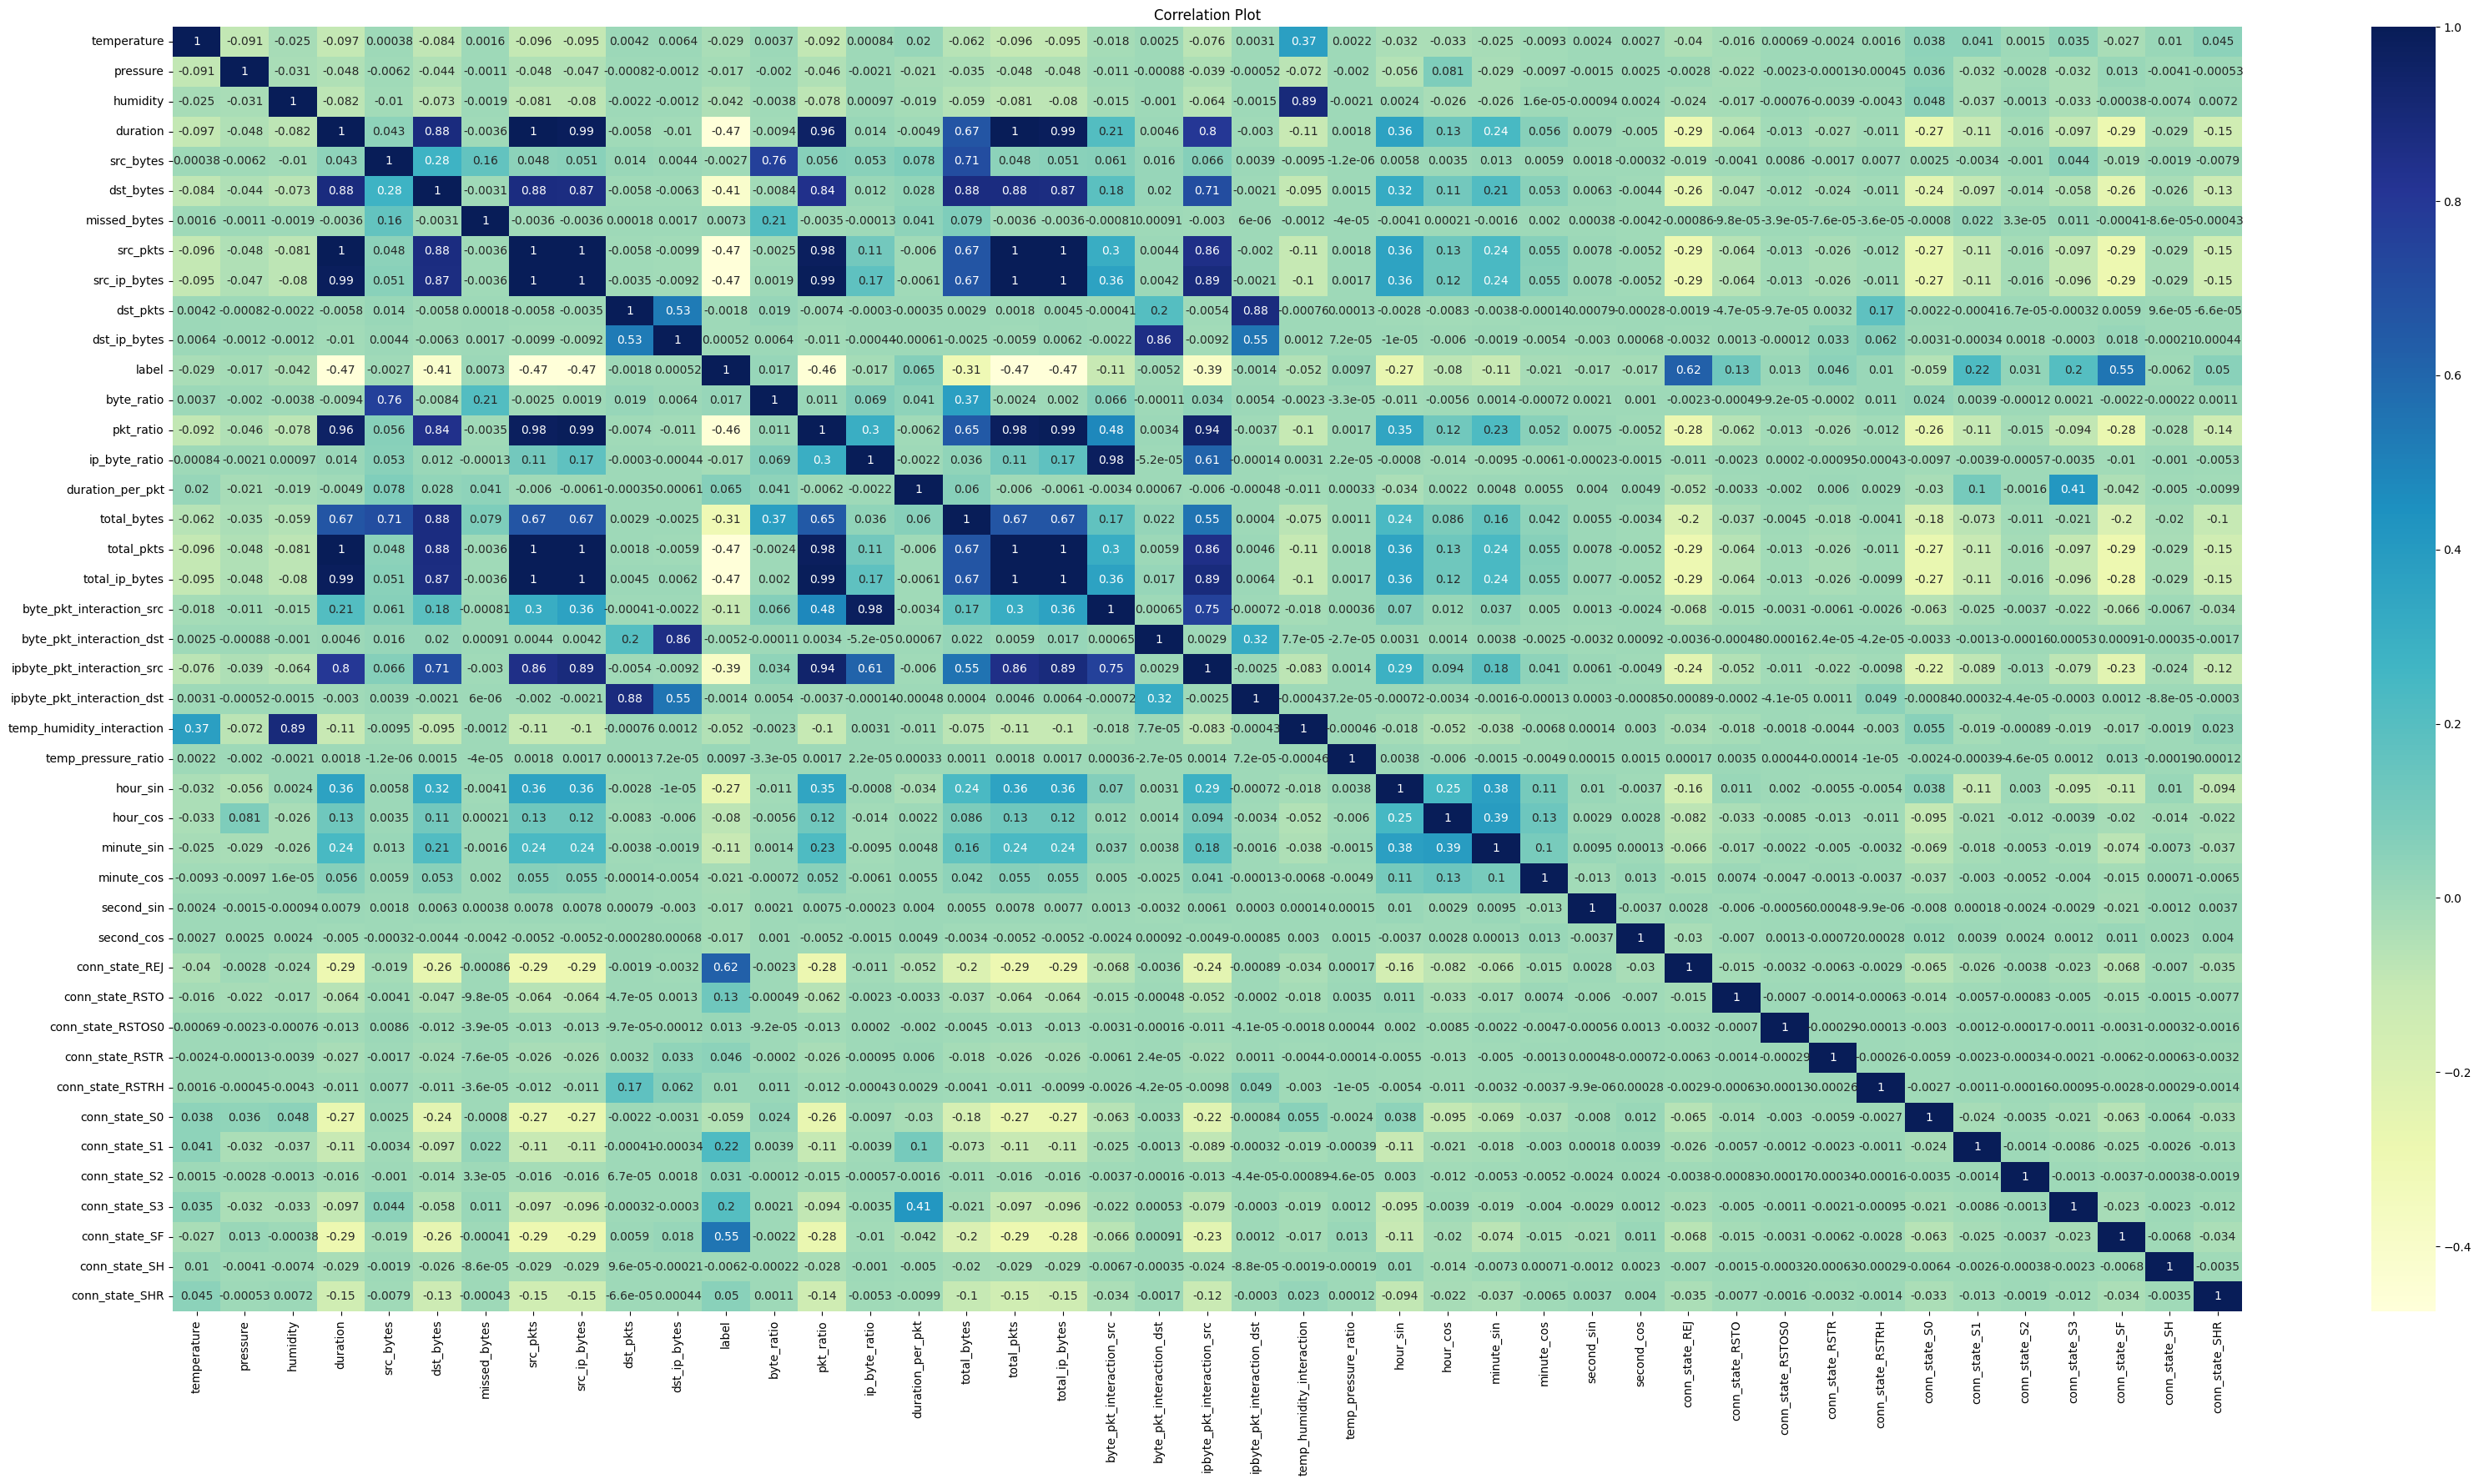

In [198]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(train_df.corr(),cmap='YlGnBu', annot=True)
plt.savefig("FeaturesCorrelationMatrix.png")

# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Print the highly correlated features
print("Highly correlated features:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")

In [199]:
# Create a set of features to drop
features_to_drop = set()

# Iterate over the highly correlated features and add one of each pair to the drop list
for feature1, feature2 in highly_correlated_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        if feature1 != 'label' and feature2 != 'label': # Binary Classification
        # if feature1 != 'type' and feature2 != 'type': # Multi-Class Classification
            features_to_drop.add(feature2)  # You can choose feature1 or feature2 to drop

# Drop the features from the DataFrame
train_df = train_df.drop(columns=features_to_drop)

# Print the remaining features
print("Remaining features after dropping highly correlated ones:")
print(train_df.columns)

Remaining features after dropping highly correlated ones:
Index(['temperature', 'pressure', 'humidity', 'duration', 'src_bytes',
       'missed_bytes', 'dst_pkts', 'dst_ip_bytes', 'label', 'ip_byte_ratio',
       'duration_per_pkt', 'total_bytes', 'temp_pressure_ratio', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0',
       'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1',
       'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH',
       'conn_state_SHR'],
      dtype='object')


In [200]:
# Binary Classification
x = train_df.drop(['label'], axis=1)
y = train_df[['label']]

# # Multi-Class Classification
# x = train_df.drop(['type'], axis=1)
# y = train_df[['type']]

print("Total features data: \n", x.count(),"\n")
print("Total target data: \n", y.count())
print()

Total features data: 
 temperature            547732
pressure               547732
humidity               547732
duration               547732
src_bytes              547732
missed_bytes           547732
dst_pkts               547732
dst_ip_bytes           547732
ip_byte_ratio          547732
duration_per_pkt       547732
total_bytes            547732
temp_pressure_ratio    547732
hour_sin               547732
hour_cos               547732
minute_sin             547732
minute_cos             547732
second_sin             547732
second_cos             547732
conn_state_REJ         547732
conn_state_RSTO        547732
conn_state_RSTOS0      547732
conn_state_RSTR        547732
conn_state_RSTRH       547732
conn_state_S0          547732
conn_state_S1          547732
conn_state_S2          547732
conn_state_S3          547732
conn_state_SF          547732
conn_state_SH          547732
conn_state_SHR         547732
dtype: int64 

Total target data: 
 label    547732
dtype: int64



In [201]:
# Binary Classification
print(train_df['label'].value_counts())

# # Multi-Class Classification
# print(train_df['type'].value_counts())

label
0    463341
1     84391
Name: count, dtype: int64


In [202]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547732 entries, 0 to 650241
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   temperature          547732 non-null  float64
 1   pressure             547732 non-null  float64
 2   humidity             547732 non-null  float64
 3   duration             547732 non-null  float64
 4   src_bytes            547732 non-null  int64  
 5   missed_bytes         547732 non-null  int64  
 6   dst_pkts             547732 non-null  int64  
 7   dst_ip_bytes         547732 non-null  int64  
 8   label                547732 non-null  int64  
 9   ip_byte_ratio        547732 non-null  float64
 10  duration_per_pkt     547732 non-null  float64
 11  total_bytes          547732 non-null  int64  
 12  temp_pressure_ratio  547732 non-null  float64
 13  hour_sin             547732 non-null  float64
 14  hour_cos             547732 non-null  float64
 15  minute_sin           5

In [203]:
# Define the desired number of samples for each class
desired_count = 30000 # Binary Classification
# desired_count = 15000 # Multi-Class Classification

# Define the oversampling strategy for SMOTE
oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}

# Define the undersampling strategy for RandomUnderSampler
undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

# Create the SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy=oversample_strategy)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

# Combine SMOTE and RandomUnderSampler in a pipeline
pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

# Print class distribution before resampling
print("Before resampling:", y.value_counts())
print()

# Apply the pipeline to resample the dataset
x_resampled, y_resampled = pipeline.fit_resample(x, y)

# Print class distribution after resampling
print("After resampling:", y_resampled.value_counts())

Before resampling: label
0        463341
1         84391
Name: count, dtype: int64

After resampling: label
0        30000
1        30000
Name: count, dtype: int64


In [204]:
x = x_resampled
y = y_resampled

In [205]:
discrete_features = x.dtypes == int

def mi_score_maker(x,y,discrete_features):
    scores = mutual_info_regression(x,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':x.columns,
        'Scores':scores
    })
    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)

mi_scores

,Features,Scores
0,dst_ip_bytes,0.690733
1,ip_byte_ratio,0.638202
2,total_bytes,0.612132
3,duration_per_pkt,0.564429
4,duration,0.543768
5,dst_pkts,0.498813
6,src_bytes,0.497905
7,pressure,0.354747
8,humidity,0.244796
9,conn_state_REJ,0.173324


In [206]:
# Filter features with scores less than 0.01
low_score_features = mi_scores[mi_scores['Scores'] < 0.01]

# Extract the feature names
low_score_feature_names = low_score_features['Features'].tolist()

# Print the list of low score feature names
low_score_feature_names

['conn_state_SHR',
 'temperature',
 'conn_state_RSTO',
 'conn_state_S0',
 'conn_state_S2',
 'conn_state_RSTOS0',
 'conn_state_RSTRH',
 'conn_state_RSTR',
 'conn_state_SH',
 'second_sin',
 'second_cos']

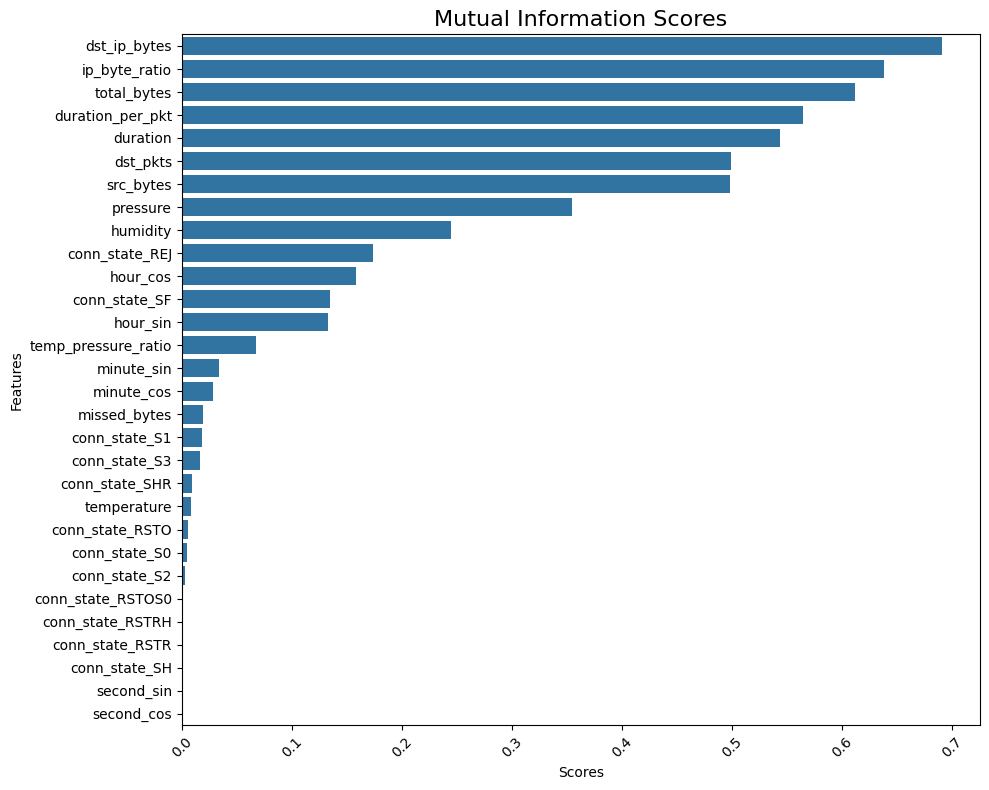

In [207]:
plt.figure(figsize=(10, 8))

# Create the barplot
sns.barplot(x='Scores', y='Features', data=mi_scores)

# Add a title
plt.title("Mutual Information Scores", fontsize=16)

# Rotate the y-axis labels (if needed)
plt.yticks(rotation=0)

# Rotate the x-axis labels (if needed)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

In [208]:
x.drop(low_score_feature_names,axis=1, inplace = True)

In [209]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
print(x_scaled)

[[5.98201671e-01 3.71072151e-01 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.05329042e-01 5.83628698e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.19243617e-01 8.01401761e-01 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.96368403e-01 8.69411897e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.30725287e-01 3.02038329e-01 1.00559246e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.73538941e-01 3.46741588e-01 1.61217576e-07 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


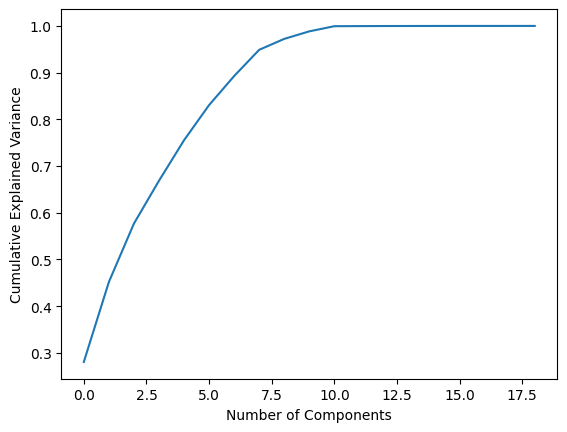

In [210]:
pca = PCA()
pca.fit(x_scaled)  # x_scaled is your training data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [211]:
# Save X_scaled (assuming it's a NumPy array)
pd.DataFrame(x_scaled).to_csv("x_scaled.csv", index=False)

# Binary Classification
# Save y_label (can be a NumPy array or Series)
pd.DataFrame(y, columns=["label"]).to_csv("y_label.csv", index=False)
print("All data saved as CSV:")
print("- x_scaled -> 'x_scaled.csv'")
print("- y -> 'y_label.csv'")

# # Multi-Class Classification
# # Save y_type (can be a NumPy array or Series)
# pd.DataFrame(y, columns=["type"]).to_csv("y_type.csv", index=False)
# print("All data saved as CSV:")
# print("- x_scaled -> 'x_scaled.csv'")
# print("- y -> 'y_type.csv'")

All data saved as CSV:
- x_scaled -> 'x_scaled.csv'
- y -> 'y_label.csv'
